# Fine-tuning for Depth Estimation with 🤗 Transformers

This notebook shows how to fine-tune a pre-trained Vision model for Depth Estimation on a custom dataset. The idea is to add a randomly initialized depth estimator head on top of a pre-trained encoder and fine-tune the model altogether on a labeled dataset.


## Dataset

This notebook uses a subset of the [DIODE dataset](https://diode-dataset.org/). We'll be using a subset of the dataset to keep the runtime of the tutorial short.  

## Model

We'll fine-tune the [GLPN model](https://huggingface.co/docs/transformers/model_doc/glpn), which was pre-trained on the [NYU dataset](https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html). You can find the other depth estimation networks on Hub with [this URL](https://huggingface.co/models?other=depth-estimation). 

**Note** that for models where there's no estimation head already available you'll have to manually attach it (randomly initialized). But this is not the case for GLPN since we already have a [`GLPNForDepthEstimation`](https://huggingface.co/docs/transformers/model_doc/glpn#transformers.GLPNForDepthEstimation) class.

## Data preprocessing

This notebook leverages [TorchVision's](https://pytorch.org/vision/stable/transforms.html) transforms for applying data preprocessing transformations including data augmentation. In addition, we also use the [`imgaug`](https://imgaug.readthedocs.io/) library for applying augmentation transforms that are compatible with input images as well as their depth maps. 

---

Depending on the model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those two parameters, then the rest of the notebook should run smoothly.

In [1]:
model_ckpt = "vinvino02/glpn-nyu" # pre-trained model from which to fine-tune
batch_size = 24 # batch size for training and evaluation

Before we start, let's install the `transformers` and `imgaug` libraries.

In [2]:
# !pip install transformers imgaug -q

If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your model with the community, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your token:

In [3]:
# from huggingface_hub import notebook_login

# notebook_login()

Then you need to install Git-LFS to upload your model checkpoints:

In [4]:
# !git config --global credential.helper store

## Fine-tuning a model on a depth estimation task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) vision models on a Depth Estimation dataset.

Given a 2D image, the goal is to estimate the depths of the different objects present inside the image.

### Preparing the dataset

We'll closely follow [this guide](https://keras.io/examples/vision/depth_estimation/) to prepare our dataset. First, we download the following:

* A subset of the training split of the DIODE dataset.
* The validation split of the DIODE dataset.

In [5]:
# from huggingface_hub import hf_hub_download


# hf_dataset_identifier = "sayakpaul/diode-subset-train"
# filename = "train_subset.tar.gz"
# train_archive_path = hf_hub_download(
#     repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"
# )

In [6]:
# from urllib import request

# url = "http://diode-dataset.s3.amazonaws.com/val.tar.gz"
# val_archive_path, _ = request.urlretrieve(url, url.split("/")[-1])

We then un-tar the archives. 

In [7]:
# import tarfile

# with tarfile.open(train_archive_path) as f:
#     f.extractall()

# with tarfile.open(val_archive_path) as f:
#     f.extractall()

We'll limit the tutorial to use images only from the `indoors`.

In [8]:
import os

variant = "indoors"
sorted(
    os.listdir(os.path.join("train_subset", variant, "scene_00000", "scan_00000"))
)[:15]

['00000_00000_indoors_050_000.png',
 '00000_00000_indoors_050_000_depth.npy',
 '00000_00000_indoors_050_000_depth_mask.npy',
 '00000_00000_indoors_060_040.png',
 '00000_00000_indoors_060_040_depth.npy',
 '00000_00000_indoors_060_040_depth_mask.npy',
 '00000_00000_indoors_060_050.png',
 '00000_00000_indoors_060_050_depth.npy',
 '00000_00000_indoors_060_050_depth_mask.npy',
 '00000_00000_indoors_070_000.png',
 '00000_00000_indoors_070_000_depth.npy',
 '00000_00000_indoors_070_000_depth_mask.npy',
 '00000_00000_indoors_070_020.png',
 '00000_00000_indoors_070_020_depth.npy',
 '00000_00000_indoors_070_020_depth_mask.npy']

`00021_00191_indoors_000_040` consider this to be the ID of an (image, depth map, mask) triplet. In this case:

* `00021_00191_indoors_000_040.png` refers to the original image
* `00021_00191_indoors_000_040_depth.npy` is the depth map
* `00021_00191_indoors_000_040_depth_mask.npy` is the mask that needs to applied to the map

Check out the [official dataset website](https://diode-dataset.org/) for more details.

In the cell, we write a utility to prepare `pandas` dataframes from the image and depth map paths for easier navigation.

In [9]:
# Reference: https://keras.io/examples/vision/depth_estimation/#-preparing-the-dataset

import pandas as pd


def prepare_data_df(dataset_root_path, variant="indoors"):
    path = os.path.join(dataset_root_path, variant)

    filelist = []

    for root, dirs, files in os.walk(path):
        for file in files:
            filelist.append(os.path.join(root, file))

    filelist.sort()
    data = {
        "image": [x for x in filelist if x.endswith(".png")],
        "depth": [x for x in filelist if x.endswith("_depth.npy")],
        "mask": [x for x in filelist if x.endswith("_depth_mask.npy")],
    }
    df = pd.DataFrame(data)
    return df


train_df = prepare_data_df("train_subset")
val_df = prepare_data_df("val")

In [10]:
train_df.head()

,image,depth,mask
0,train_subset/indoors/scene_00000/scan_00000/00...,train_subset/indoors/scene_00000/scan_00000/00...,train_subset/indoors/scene_00000/scan_00000/00...
1,train_subset/indoors/scene_00000/scan_00000/00...,train_subset/indoors/scene_00000/scan_00000/00...,train_subset/indoors/scene_00000/scan_00000/00...
2,train_subset/indoors/scene_00000/scan_00000/00...,train_subset/indoors/scene_00000/scan_00000/00...,train_subset/indoors/scene_00000/scan_00000/00...
3,train_subset/indoors/scene_00000/scan_00000/00...,train_subset/indoors/scene_00000/scan_00000/00...,train_subset/indoors/scene_00000/scan_00000/00...
4,train_subset/indoors/scene_00000/scan_00000/00...,train_subset/indoors/scene_00000/scan_00000/00...,train_subset/indoors/scene_00000/scan_00000/00...


### Loading the model

In the next cell, we initialize a depth estimation model. We also initialize the feature extractor associated to the model. This will come in handy during pushing the model checkpoints to the Hub. The feature extractor also contains information about how the dataset needs to be preprocessed. 

In [11]:
from transformers import GLPNFeatureExtractor, GLPNForDepthEstimation


feature_extractor = GLPNFeatureExtractor.from_pretrained(model_ckpt)
model = GLPNForDepthEstimation.from_pretrained(model_ckpt)

In [12]:
import torch.nn as nn 
import torch


# Copied from transformers.models.segformer.modeling_segformer.SegformerPreTrainedModel._init_weights
def init_weights(model):
    def fn(module):
        """Initialize the weights"""
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=model.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=model.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
    return fn


init_fn = init_weights(model)
# _ = model.decoder.apply(init_fn)
_ = model.head.apply(init_fn)

### Preparing datasets for training and evaluation

In the next cell, we define a `DIODEDataset` to prepare datasets for training and evaluation.

In [13]:
import torch
import torchvision
import numpy as np
import PIL

from imgaug import augmenters as iaa
import imgaug as ia


class DIODEDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transformation_chain, input_only=None):
        """
        Args:
            dataframe: pandas dataframe containing image path, depth map, and validity mask
            transformation_chain: composed chain of preprocessing transformations for data
            input_only (optional, str or List[str]): to denote the preprocessing layers to be discarded
                from `imgaug` transformation chain

        References:
            a. https://keras.io/examples/vision/depth_estimation/
            b. https://github.com/fabioperez/pytorch-examples/blob/master/notebooks/PyTorch_Data_Augmentation_Image_Segmentation.ipynb
        """
        self.dataframe = dataframe
        self.transformation_chain = transformation_chain
        self.min_depth = 0.1
        self.input_only = input_only
        self.to_tensor = torchvision.transforms.ToTensor()

    def _process_depth_map(self, depth_map: np.ndarray, mask: np.ndarray):
        mask = mask > 0
        max_depth = min(300, np.percentile(depth_map, 99))
        depth_map = np.clip(depth_map, self.min_depth, max_depth)
        depth_map = np.log(depth_map, where=mask)

        depth_map = np.ma.masked_where(~mask, depth_map)

        depth_map = np.clip(depth_map, self.min_depth, np.log(max_depth))
        depth_map = np.expand_dims(depth_map, axis=2)
        return depth_map

    def _activator_masks(self, images, augmenter, parents, default):
        if self.input_only and augmenter.name in self.input_only:
            return False
        else:
            return default

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]["image"]
        depth_map_path = self.dataframe.iloc[idx]["depth"]
        mask_path = self.dataframe.iloc[idx]["mask"]

        image = PIL.Image.open(image_path).convert("RGB")
        image = np.asarray(image)

        depth_map = np.load(depth_map_path).squeeze()
        mask = np.load(mask_path)
        depth_map = self._process_depth_map(depth_map, mask)

        if self.input_only:
            det_tf = self.transformation_chain.to_deterministic()
            image = det_tf.augment_image(image)
            depth_map = det_tf.augment_image(
                depth_map, hooks=ia.HooksImages(activator=self._activator_masks)
            )
            image = self.to_tensor(image)
            depth_map = self.to_tensor(depth_map.copy())
        else:
            image = self.transformation_chain(image)
            depth_map = self.transformation_chain(depth_map)
        return {"image": image, "depth_map": depth_map}

The `_activator_masks()` utility (courtesy of [this notebook]( https://github.com/fabioperez/pytorch-examples/blob/master/notebooks/PyTorch_Data_Augmentation_Image_Segmentation.ipynb)) ensures that certain augmentation transformations are only applied to the input image and NOT to the depth maps. 

Next, we define two separate transformation chains: one for training and another one for validation as well as evaluation. Since our training dataset is quite small, training with data augmentation can be crucial.

In [14]:
# Heatmap transformations: https://imgaug.readthedocs.io/en/latest/source/examples_heatmaps.html

resize_to = (512, 512)

train_transform_chain = iaa.Sequential(
    [
        iaa.Resize(resize_to, interpolation="linear"),
        iaa.Fliplr(0.3),  # affects heatmaps
        iaa.Sharpen((0.0, 1.0), name="sharpen"),  # sharpen (only) image
        iaa.Sometimes(
            0.5, iaa.Affine(rotate=(-45, 45))
        ),  # rotate by -45 to 45 degrees (affects heatmaps)
        iaa.Sometimes(
            0.5, iaa.ElasticTransformation(alpha=50, sigma=5)
        ),  # apply water effect (affects heatmaps)
    ],
    random_order=True,
)

test_transformation_chain = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize(resize_to),
        torchvision.transforms.ToTensor(),
    ]
)

In [15]:
train_dataset = DIODEDataset(train_df, train_transform_chain, ["sharpen"])
validation_dataset = DIODEDataset(val_df, test_transformation_chain)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")

Training dataset size: 1715
Validation dataset size: 325


Notice how we specified that the `sharpen` transformation is an input-only transformation i.e., it should not be applied to the depth maps. 

### Visualization

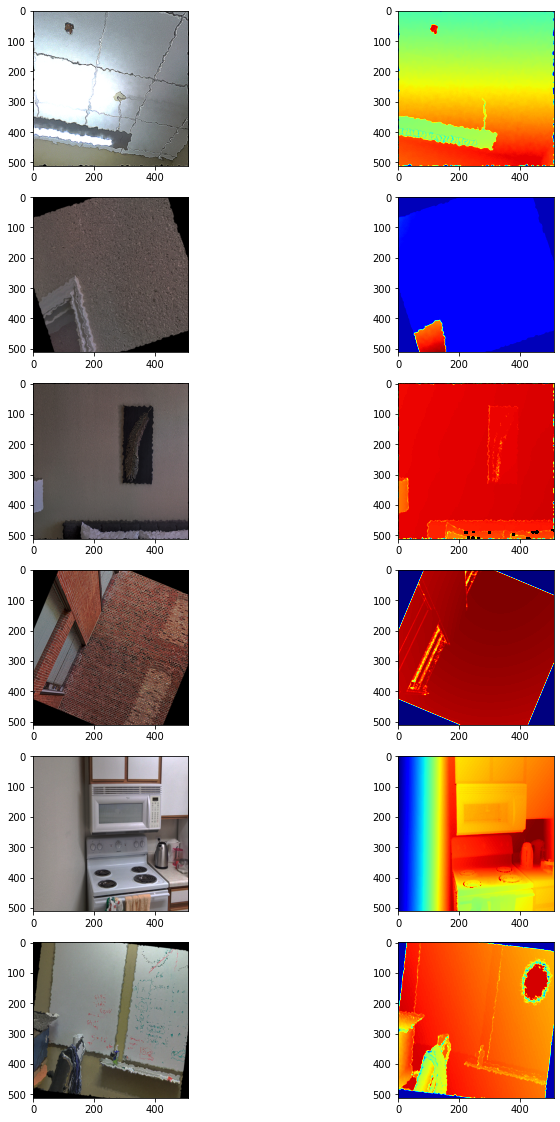

In [16]:
import matplotlib.pyplot as plt
import torch


def visualize_depth_map(samples, model=None):
    # Reference: https://keras.io/examples/vision/depth_estimation/#visualizing-samples
    input, target = samples["image"], samples["depth_map"]
    cmap = plt.cm.jet
    cmap.set_bad(color="black")

    if model:
        device = model.device
        inputs = {"pixel_values": input.to(device)}
        with torch.no_grad():
            outputs = model(**inputs).predicted_depth
        fig, ax = plt.subplots(6, 3, figsize=(12, 20))
        for i in range(6):
            ax[i, 0].imshow(input[i].permute(1, 2, 0).numpy().astype("float32"))
            ax[i, 1].imshow(target[i].permute(1, 2, 0).numpy().squeeze(), cmap=cmap)
            ax[i, 2].imshow(outputs[i].cpu().numpy().squeeze(), cmap=cmap)

    else:
        fig, ax = plt.subplots(6, 2, figsize=(12, 20))
        for i in range(6):
            ax[i, 0].imshow(input[i].permute(1, 2, 0).numpy().astype("float32"))
            ax[i, 1].imshow(target[i].permute(1, 2, 0).numpy().squeeze(), cmap=cmap)


temp_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
visualize_samples = next(iter(temp_dataloader))
visualize_depth_map(visualize_samples)

We can also visualize the (random) model predictions.

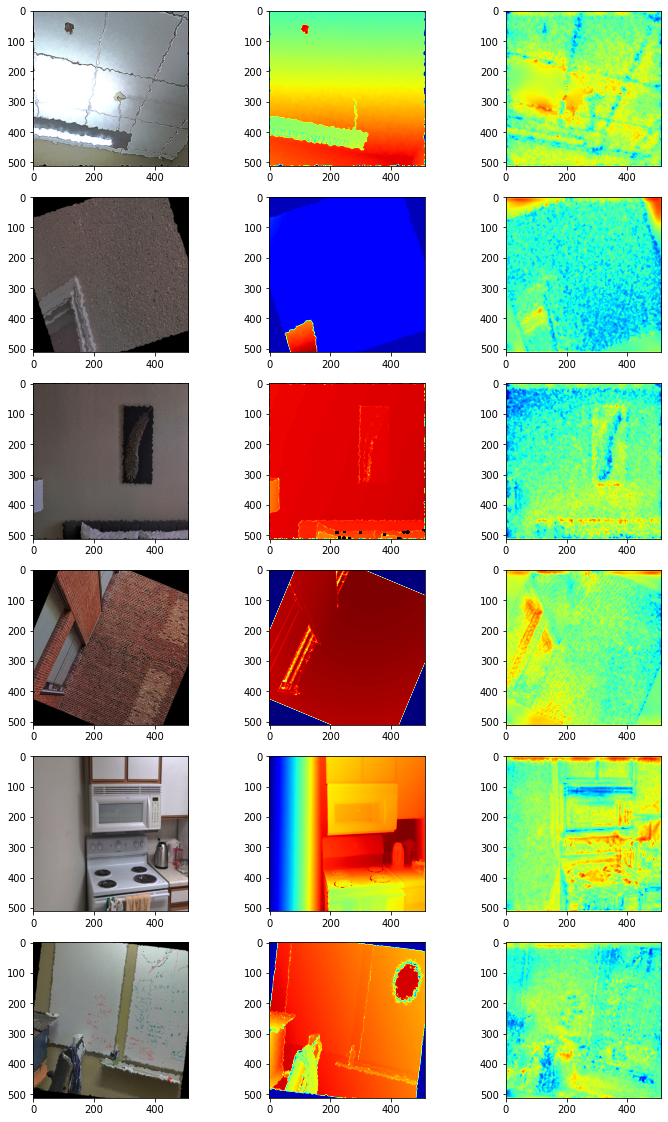

In [17]:
visualize_depth_map(visualize_samples, model)

### Training the model

To instantiate a `Trainer`, we will need to define the training configuration and the evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model.

Most of the training arguments are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values' (which is a mandatory key our model expects in its inputs).

In [18]:
from transformers import TrainingArguments, Trainer


model_name = model_ckpt.split("/")[-1]
batch_size = 24
num_epochs = 10

args = TrainingArguments(
    f"{model_name}-finetuned-diode",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=2 * batch_size,
    gradient_accumulation_steps=1,
    num_train_epochs=num_epochs,
    warmup_ratio=0.2,
    logging_steps=25,
    load_best_model_at_end=True,
    push_to_hub=True,
    fp16=True,
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved at the end of training. By default, `Trainer` will load the best model w.r.t the `loss` quantity. However, we can also specify `metric_for_best_model` in the trainer argument if we want `Trainer` to use some other metric to be used during training.

The last argument `push_to_hub` allows the Trainer to push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally with a name that is different from the name of the repository, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"nielsr/vit-finetuned-cifar10"` or `"huggingface/nielsr/vit-finetuned-cifar10"`).

Next, we need to define a function for how to compute the metrics from the predictions. There are several metrics that we can report for depth estimation (refer to the [GLPN paper](https://arxiv.org/abs/2201.07436) for details). Here we'll use the [RMSE metric](https://www.statisticshowto.com/probability-and-statistics/regression-analysis/rmse-root-mean-square-error/). 

In [19]:
import numpy as np


def compute_metrics(eval_pred):
    """Computes RMSE on a batch of predictions"""
    logits, labels = eval_pred
    rmse = (labels - logits) ** 2
    rmse = np.sqrt(rmse.mean())
    return {"rmse": rmse}

We also define a `collate_fn`, which will be used to batch examples together.
Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [20]:
def collate_fn(examples):
    pixel_values = torch.stack([example["image"] for example in examples])
    labels = torch.stack([example["depth_map"].squeeze() for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [21]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

/content/glpn-nyu-finetuned-diode is already a clone of https://huggingface.co/sayakpaul/glpn-nyu-finetuned-diode. Make sure you pull the latest changes with `repo.git_pull()`.
Using cuda_amp half precision backend


You might wonder why we pass along the `feature_extractor` as a tokenizer when we already preprocessed our data. This is only to make sure the feature extractor configuration file (stored as JSON) will also be uploaded to the repo on the hub.

Now we can finetune our model by calling the `train()` method:

In [22]:
train_results = trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1715
  Num Epochs = 10
  Instantaneous batch size per device = 24
  Total train batch size (w. parallel, distributed & accumulation) = 24
  Gradient Accumulation steps = 1
  Total optimization steps = 720
  Number of trainable parameters = 61220903


Epoch,Training Loss,Validation Loss,Rmse
1,1.700300,1.382095,nan
2,1.506700,1.060243,nan
3,0.833100,0.740559,nan
4,0.714700,0.646672,nan
5,0.694900,0.627837,nan
6,0.642400,0.598799,0.631000
7,0.619100,0.607560,0.648740
8,0.616400,0.596635,nan
9,0.592000,0.586788,nan
10,0.577100,0.585273,nan


***** Running Evaluation *****
  Num examples = 325
  Batch size = 48
Saving model checkpoint to glpn-nyu-finetuned-diode/checkpoint-72
Configuration saved in glpn-nyu-finetuned-diode/checkpoint-72/config.json
Model weights saved in glpn-nyu-finetuned-diode/checkpoint-72/pytorch_model.bin
Feature extractor saved in glpn-nyu-finetuned-diode/checkpoint-72/preprocessor_config.json
Feature extractor saved in glpn-nyu-finetuned-diode/preprocessor_config.json
Several commits (3) will be pushed upstream.
***** Running Evaluation *****
  Num examples = 325
  Batch size = 48
Saving model checkpoint to glpn-nyu-finetuned-diode/checkpoint-144
Configuration saved in glpn-nyu-finetuned-diode/checkpoint-144/config.json
Model weights saved in glpn-nyu-finetuned-diode/checkpoint-144/pytorch_model.bin
Feature extractor saved in glpn-nyu-finetuned-diode/checkpoint-144/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 325
  Batch size = 48
Saving model checkpoint to glpn-nyu-finetu

We can now run evaluation with the `evaluate()` method of `Trainer`: 

In [23]:
trainer.evaluate(validation_dataset)

***** Running Evaluation *****
  Num examples = 325
  Batch size = 48


{'eval_loss': 0.5927334427833557,
 'eval_rmse': nan,
 'eval_runtime': 29.3171,
 'eval_samples_per_second': 11.086,
 'eval_steps_per_second': 0.239,
 'epoch': 10.0}

You can now upload the result of the training to the Hub, just execute this instruction (note that the Trainer will automatically create a model card as well as Tensorboard logs - see the "Training metrics" tab - amazing isn't it?):

In [24]:
# kwargs = {
#     "tags": ["vision", "depth-estimation"],
#     "finetuned_from": model_ckpt,
#     "dataset": "diode-subset",
# }

# trainer.push_to_hub(**kwargs)

## Inference

Now we can load the fine-tuned model and run inference with it. 

In [25]:
# finetuned_model = GLPNForDepthEstimation.from_pretrained(
#     f"sayakpaul/{model_name}-finetuned-diode"
# )
finetuned_model = trainer.model

# We create a sample data loader with the tes set.
temp_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=8)
test_samples = next(iter(temp_dataloader))

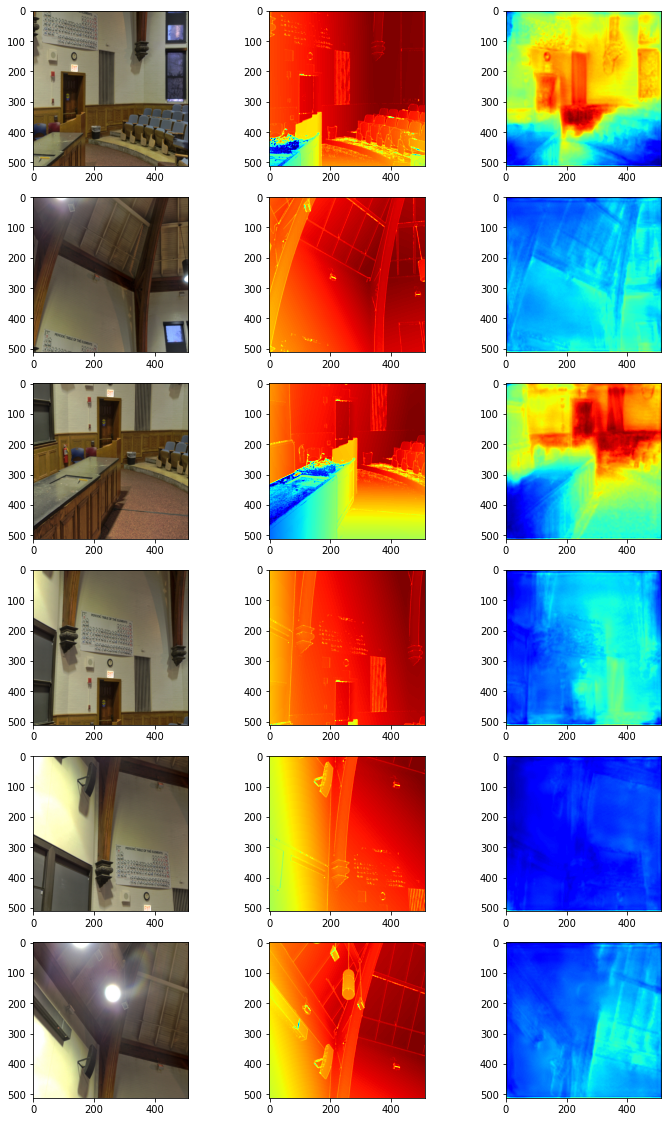

In [26]:
visualize_depth_map(test_samples, finetuned_model)

## Pipeline API

An alternative way to quickly perform inference with any model on the hub is by leveraging the [Pipeline API](https://huggingface.co/docs/transformers/main_classes/pipelines), which abstracts away all the steps we did manually above for us. It will perform the preprocessing, forward pass and postprocessing all in a single object. 

Let's showcase this for our trained model:

TODO